#  Dog Breed Identification


#### Import Dependencies

In [32]:
from __future__ import division, print_function

%matplotlib inline

import os, sys, random
from importlib import reload  # Python 3
import numpy as np
import shutil
from glob import glob
import pandas as pd
from copy import deepcopy
from IPython.display import FileLink
from PIL import Image

In [2]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using TensorFlow backend.


#### Define Constants

In [3]:
LABEL_LIST = "breedList.txt"
ID_MAP = "labels.csv"

STORAGE_DIR = "/home/tyler/storage/dogbreed/"
TEST_DIR = STORAGE_DIR + "test/"
TRAIN_DIR = STORAGE_DIR + "train/"
VAL_DIR = STORAGE_DIR + "valid/"

SAMPLE_DIR = STORAGE_DIR + "sample/"
SAMPLE_TRAIN = SAMPLE_DIR + "train/"
SAMPLE_VAL = SAMPLE_DIR + "valid/"

RESULTS_DIR = STORAGE_DIR + "results/"
RESULT_FILE = RESULTS_DIR + 'dogbreeds.csv'

MODELS_PATH = 'http://files.fast.ai/models/models/' 

#### Define Directory Structure

In [4]:
%cd $STORAGE_DIR

if not os.path.isdir(TRAIN_DIR):
    %mkdir $TRAIN_DIR

if not os.path.isdir(VAL_DIR):
    %mkdir $VAL_DIR
    
if not os.path.isdir(SAMPLE_DIR):
    %mkdir $SAMPLE_DIR
    
if not os.path.isdir(SAMPLE_TRAIN):
    %mkdir $SAMPLE_TRAIN

if not os.path.isdir(SAMPLE_VAL):
    %mkdir $SAMPLE_VAL
    
if not os.path.isdir(RESULTS_DIR):
    %mkdir $RESULTS_DIR

/home/tyler/storage/dogbreed


#### Sort Data By Label

In [5]:
def processLabels(labels, path):
    %cd $path
    for label in labels:
        if not os.path.isdir(label):
            %mkdir $label

In [6]:
def selectRandomFiles(num, path):
    if len(os.listdir(path)) < num:
        num = len(os.listdir(path))
        
    selected = []
    while num >= len(selected):
            choice = random.choice(os.listdir(path))
            if choice not in selected:
                selected.append(choice)
    return selected

In [7]:
def createSampleSet(labels, samplePath, sourcePath, num):
    processLabels(labels, samplePath)
    for label in labels:
        existing = len(os.listdir(samplePath + label + "/"))
        if existing < num:
            files = selectRandomFiles(num - existing, sourcePath + label + "/")
            for file in files:
                src = sourcePath + label + "/" + file
                dest = samplePath + label + "/"
                shutil.copy2(src, dest)

In [8]:
def removeUnsortedFiles(path):
    files = glob(path + "*.jpg")
    for file in files:
        os.remove(file)

In [9]:
def createTrainingSet(labels, items):
    processLabels(labels, TRAIN_DIR)
    for item in items:
        file = TRAIN_DIR + item[0] + ".jpg"
        dest = TRAIN_DIR + item[1] + "/" + item[0] + ".jpg"
        if os.path.isfile(file):
            shutil.copy2(file, dest)
    createSampleSet(labels, SAMPLE_TRAIN, TRAIN_DIR, 16)
    removeUnsortedFiles(TRAIN_DIR)

In [10]:
def createValidationSet(lables):
    processLabels(labels, VAL_DIR)
    for label in labels:
        existing = len(os.listdir(VAL_DIR + label))
        if(existing > 0):
             continue
        files = os.listdir(TRAIN_DIR + label)
        numForValid = int(np.ceil(len(files) * .2))
        for file in files[-numForValid:]:
            src = TRAIN_DIR + label + "/" + file
            dest = VAL_DIR + label + "/" + file
            shutil.copy2(src , dest)
            os.remove(src)
    createSampleSet(labels, SAMPLE_VAL, VAL_DIR, 4)

In [11]:
def sortData(labels):
    items = np.loadtxt(STORAGE_DIR + ID_MAP, delimiter=',', dtype=str, skiprows=1)
    createTrainingSet(labels, items)
    createValidationSet(labels)

In [12]:
def getLabels():
    if os.path.isfile(STORAGE_DIR + LABEL_LIST):
        try: 
            f = open(STORAGE_DIR + LABEL_LIST, 'r')
            fileString = f.read()
            return fileString.splitlines()
        except IOError:
            print("Could not read file: ", LABEL_LIST)
    return []

In [13]:
labels = getLabels()
num_labels = len(labels)

In [14]:
sortData(labels)

/home/tyler/storage/dogbreed/train
/home/tyler/storage/dogbreed/sample/train
/home/tyler/storage/dogbreed/valid
/home/tyler/storage/dogbreed/sample/valid


#### Define Model

In [15]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [16]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [17]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [18]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [19]:
model = VGG_16()
for layer in model.layers: layer.trainable=False

#### Get Pretrained Weights

In [20]:
fpath = get_file('vgg16.h5', MODELS_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [ ]:
model.pop()
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
batch_size = 16
no_of_epochs = 3

In [ ]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [ ]:
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

batches = get_batches(TRAIN_DIR, gen=train_datagen, batch_size=batch_size)
val_batches = get_batches(VAL_DIR,gen=test_datagen, batch_size=batch_size*2)

batches.nb_class = batches.num_class
batches.nb_sample = batches.samples

val_batches.nb_class = batches.num_class
val_batches.nb_sample = val_batches.samples

#### Train Model

In [ ]:
def fit(batches, val_batches, batch_size, nb_epoch=1):
        model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)), epochs=nb_epoch,
                validation_data=val_batches, validation_steps=int(np.ceil(val_batches.samples/batch_size)))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print ("Running epoch: %d" % epoch)
    fit(batches, val_batches, batch_size, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    model.save_weights(RESULTS_DIR+latest_weights_filename)
print ("Completed %s fit operations" % no_of_epochs)

In [ ]:
def test(self, path, batch_size=8):
        test_batches = self.get_batches(path, shuffle=False, batch_size=batch_size, class_mode=None)
        return test_batches, self.model.predict_generator(test_batches, int(np.ceil(test_batches.samples/batch_size)))

In [ ]:
model.load_weights(RESULTS_DIR + "ft2.h5")
batches, preds = test(TEST_DIR, batch_size = batch_size*2)

#### Generate Kaggle Submission

In [ ]:
filenames = batches.filenames
ids = np.array([str(f[8:f.find('.')]) for f in filenames])

In [ ]:
columns = deepcopy(labels)
columns.insert(0, "id")

clipped = preds.clip(min=0.02, max=0.98)
rows = []

for index, row in enumerate(clipped):
    row = row.tolist()
    row.insert(0, ids[index])
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)

In [ ]:
df.to_csv(RESULT_FILE, sep=',', index=False)

In [ ]:
%cd ~/notebooks/courses/deeplearning1/nbs/
FileLink("dogbreeds.csv")

#### Plot Utils

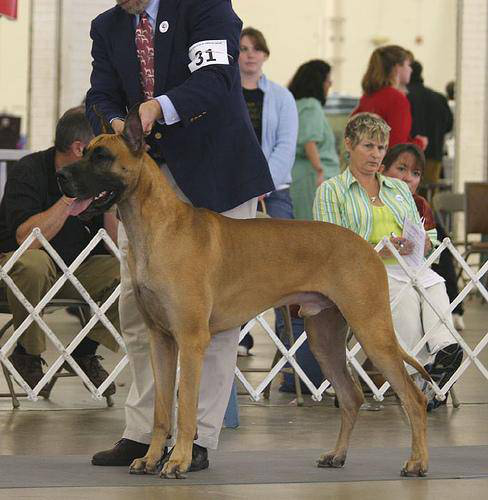

In [50]:
plot_dir = VAL_DIR + "great_dane/"
filenames = os.listdir(plot_dir)

Image.open(plot_dir + filenames[5])